In [34]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [55]:
mods = ['bcc-csm1-1','CCSM4','CSIRO-Mk3-6-0','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MPI-ESM-LR','MRI-CGCM3','NorESM1-M']

In [90]:
mpl.rcParams['xtick.labelsize']       = 11
mpl.rcParams['ytick.labelsize']       = 11
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 11
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 11
mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .2
mpl.rcParams['figure.subplot.top']    = .9
mpl.rcParams['figure.subplot.left']   = .15
mpl.rcParams['figure.subplot.right']  = .95
mpl.rcParams['figure.subplot.wspace'] = .15
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,5
mpl.rcParams['savefig.transparent']   = True
mpl.rcParams['axes.labelcolor']       = 'w'
mpl.rcParams['xtick.color']           = 'w'
mpl.rcParams['ytick.color']           = 'w'
mpl.rcParams['text.color']            = 'w'
mpl.rcParams["legend.frameon"] = False

cols = {}
cols['ocean'] = (209/255.,229/255.,240/255.)
cols['land'] = (245/255.,245/255.,245/255.)

In [91]:
#Get 1x1 degree grid
with xr.open_dataset('data/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('data/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('data/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'data/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [92]:
scen = 'rcp45'



In [93]:
with xr.open_dataset(f'data/rsl/{mods[0]}_{scen}.nc') as ds:
    lon = ds['lon'].values
    lat = ds['lat'].values
mm = np.zeros((len(mods),len(lat),len(lon)))

for m,model in enumerate(mods):
    with xr.open_dataset(f'data/rsl/{model}_{scen}.nc') as ds:
        mm[m,:,:] = np.nanmean(ds['SLR'][-20:,:,:].values,axis=0)
        
mms = np.nanstd(mm,axis=0)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [94]:
srocc = np.zeros((len(mods),len(lat),len(lon)))
zos = np.zeros((len(mods),len(lat),len(lon)))
ster = np.zeros((len(mods),len(lat),len(lon)))
adyn = np.zeros((len(mods),len(lat),len(lon)))
asmb = np.zeros((len(mods),len(lat),len(lon)))
gsmb = np.zeros((len(mods),len(lat),len(lon)))
glac = np.zeros((len(mods),len(lat),len(lon)))

for m,model in enumerate(mods):

    #Get zos
    file = f'data/CorrectedZOS/CorrectedZOS_EXP{scen}_{model}.nc'
    with xr.open_dataset(file) as ds:
        zos[m,:,:] = ds['CorrectedZOS_reg'].values

    #Add steric expansion    
    with xr.open_dataset(f'data/steric/{model}_{scen}.nc') as ds:
        ster[m,:,:] = np.nanmean(ds['SLR'][-20:].values)
    
    #Add Antarctic dyn
    with xr.open_dataset(f'data/Adyn/{model}_{scen}.nc') as ds:
        adyn[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a
        
    #Add Antarctic smb
    with xr.open_dataset(f'data/Asmb/{model}_{scen}.nc') as ds:
        asmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a     
    
    #Add Greenland smb
    with xr.open_dataset(f'data/Gsmb/{model}_{scen}.nc') as ds:  
        gsmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_gr
    
    #Add glaciers
    for r in range(1,20):
        with xr.open_dataset(f'data/glacier/{model}_{scen}_{r}.nc') as ds:
            glac[m,:,:] += np.nanmean(ds['SLR'][-20:].values)*fp_gl[r-1,:,:]

def sig(var):
    return np.nanstd(var,axis=0)
            
srocc = ((sig(zos)+sig(ster)+sig(asmb)+sig(gsmb))**2+sig(glac)**2+sig(adyn)**2)**.5

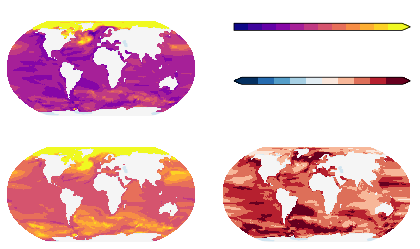

In [97]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

fig = plt.figure()

ax = fig.add_subplot(221,projection=ccrs.Robinson())
im = ax.pcolormesh(lon,lat,mms,transform=ccrs.PlateCarree(),vmin=0,vmax=20,cmap=plt.get_cmap('plasma',12))
makeglobal(ax)
ax.set_title('REAL ensemble spread')

ax = fig.add_subplot(223,projection=ccrs.Robinson())
im = ax.pcolormesh(lon,lat,srocc,transform=ccrs.PlateCarree(),vmin=0,vmax=20,cmap=plt.get_cmap('plasma',12))
makeglobal(ax)
ax.set_title('SROCC codependence')

ax = fig.add_subplot(224,projection=ccrs.Robinson())
im2 = ax.pcolormesh(lon,lat,100.*np.abs((srocc-mms)/mms),transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=plt.get_cmap('RdBu_r',10))
makeglobal(ax)
ax.set_title('diff SROCC-REAL')

cax = fig.add_axes([.6,.83,.35,.02])
cb = plt.colorbar(im,cax=cax,extend='max',orientation='horizontal')
cb.set_label('Uncertainty in RSL (cm)')

cax = fig.add_axes([.6,.68,.35,.02])
cb = plt.colorbar(im2,cax=cax,extend='both',orientation='horizontal')
cb.set_label('Difference (percent)')

plt.savefig('figures/posterplot_regunc.pdf')
plt.show()
plt.close()